In [4]:
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/a7/68/16e7b9154fae61fb29f0f3450b39b855b89e6d2c598d67302e70f96883af/matplotlib-3.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/67/0f/6e5b4879594cd1cbb6a2754d9230937be444f404cf07c360c07a10b36aac/contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/67/09/e09ee013d9d6f2f006147e5fc2b4d807eb2931f4f890c2d4f711e10391d7/fonttools-4.51.0-cp310-cp310-manylinux_2_17_x86_64.manylinux20

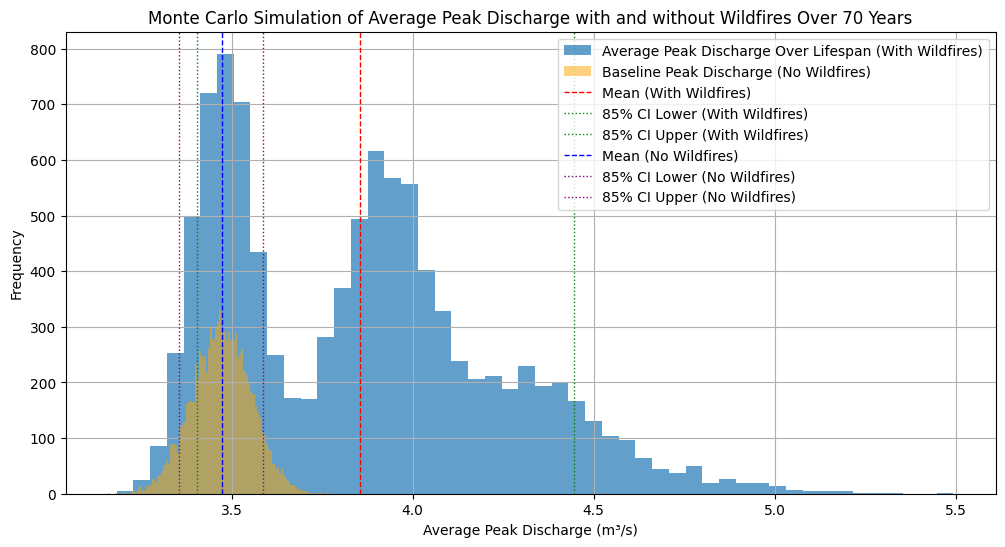

Baseline (No Wildfires): Mean = 3.47 m³/s, Std Dev = 0.08 m³/s
Baseline (No Wildfires): 85% CI = (3.36, 3.59) m³/s
Average Peak Discharge Over Lifespan (With Wildfires): Mean = 3.85 m³/s, Std Dev = 0.37 m³/s
Average Peak Discharge Over Lifespan (With Wildfires): 85% CI = (3.41, 4.45) m³/s
Average Number of Wildfires Over Lifespan: 1.05


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the input parameters
mean_C_baseline = 0.25
std_C_baseline = 0.05
mean_C_post_wildfire = 0.40
std_C_post_wildfire = 0.10

rainfall_intensity = 50  # mm/hr, assume a constant for simplicity
drainage_area = 100  # hectares

# Annual probability of wildfire occurrence
prob_wildfire_annual = 0.015
design_lifespan_years = 70
fire_effect_duration = 15  # years

# Number of simulations
num_simulations = 10000

# Generate random samples for baseline C values (no wildfire effects)
C_baseline_samples = np.random.normal(mean_C_baseline, std_C_baseline, (num_simulations, design_lifespan_years))

# Generate random samples for post-wildfire C values
C_post_wildfire_samples = np.random.normal(mean_C_post_wildfire, std_C_post_wildfire, (num_simulations, design_lifespan_years))

# Convert drainage area from hectares to square meters for calculation
drainage_area_m2 = drainage_area * 10000

# Convert rainfall intensity from mm/hr to m/s for calculation
rainfall_intensity_m_s = rainfall_intensity / 3600000

# Initialize arrays to store peak discharges
Q_samples = np.zeros((num_simulations, design_lifespan_years))
Q_baseline_discharge = np.zeros((num_simulations, design_lifespan_years))

# Simulate wildfire occurrences and their effects on C values
wildfire_occurrences = np.random.binomial(1, prob_wildfire_annual, (num_simulations, design_lifespan_years))
for sim in range(num_simulations):
    # Initialize C values for each simulation
    C_values = np.copy(C_baseline_samples[sim])  # Start with baseline C values
    
    for year in range(design_lifespan_years):
        if wildfire_occurrences[sim, year] == 1:
            # Apply increased C value for the duration of the fire effect
            end_effect_year = min(year + fire_effect_duration, design_lifespan_years)
            C_values[year:end_effect_year] = C_post_wildfire_samples[sim, year:end_effect_year]
    
    # Calculate peak discharges for each year in the simulation
    Q_samples[sim, :] = C_values * rainfall_intensity_m_s * drainage_area_m2

# Calculate baseline discharge with variable C without wildfire effects
Q_baseline_discharge = C_baseline_samples * rainfall_intensity_m_s * drainage_area_m2

# Calculate average peak discharge over the lifespan
Q_avg_lifespan = np.mean(Q_samples, axis=1)
Q_avg_baseline = np.mean(Q_baseline_discharge, axis=1)

# Calculate the 85% confidence intervals
confidence_level = 0.85
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

Q_avg_lower = np.percentile(Q_avg_lifespan, lower_percentile)
Q_avg_upper = np.percentile(Q_avg_lifespan, upper_percentile)

Q_baseline_lower = np.percentile(Q_avg_baseline, lower_percentile)
Q_baseline_upper = np.percentile(Q_avg_baseline, upper_percentile)

# Calculate the average number of wildfires over the lifespan
avg_num_wildfires = np.mean(np.sum(wildfire_occurrences, axis=1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.hist(Q_avg_lifespan, bins=50, alpha=0.7, label='Average Peak Discharge Over Lifespan (With Wildfires)')
plt.hist(Q_avg_baseline, bins=100, alpha=0.5, label='Baseline Peak Discharge (No Wildfires)', color='orange')

plt.axvline(np.mean(Q_avg_lifespan), color='red', linestyle='dashed', linewidth=1, label='Mean (With Wildfires)')
plt.axvline(Q_avg_lower, color='green', linestyle='dotted', linewidth=1, label='85% CI Lower (With Wildfires)')
plt.axvline(Q_avg_upper, color='green', linestyle='dotted', linewidth=1, label='85% CI Upper (With Wildfires)')

plt.axvline(np.mean(Q_avg_baseline), color='blue', linestyle='dashed', linewidth=1, label='Mean (No Wildfires)')
plt.axvline(Q_baseline_lower, color='purple', linestyle='dotted', linewidth=1, label='85% CI Lower (No Wildfires)')
plt.axvline(Q_baseline_upper, color='purple', linestyle='dotted', linewidth=1, label='85% CI Upper (No Wildfires)')

plt.xlabel('Average Peak Discharge (m³/s)')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation of Average Peak Discharge with and without Wildfires Over 70 Years')
plt.legend()
plt.grid(True)
plt.show()

# Print statistical summaries
print(f"Baseline (No Wildfires): Mean = {np.mean(Q_avg_baseline):.2f} m³/s, Std Dev = {np.std(Q_avg_baseline):.2f} m³/s")
print(f"Baseline (No Wildfires): 85% CI = ({Q_baseline_lower:.2f}, {Q_baseline_upper:.2f}) m³/s")
print(f"Average Peak Discharge Over Lifespan (With Wildfires): Mean = {np.mean(Q_avg_lifespan):.2f} m³/s, Std Dev = {np.std(Q_avg_lifespan):.2f} m³/s")
print(f"Average Peak Discharge Over Lifespan (With Wildfires): 85% CI = ({Q_avg_lower:.2f}, {Q_avg_upper:.2f}) m³/s")
print(f"Average Number of Wildfires Over Lifespan: {avg_num_wildfires:.2f}")
